In [1]:
import tensorflow as tf
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import readData
PH = 30
category = 'epoch300'
datapath = 'data/sch'

filename = os.listdir(datapath)
train_data_name = []
test_data_name = []

for fn in filename:
    if fn.find("test") != -1:
        test_data_name.append(fn)
    elif fn.find("train") != -1:
        train_data_name.append(fn)
        
print(train_data_name)
A1cList = []
A1c_train = []
A1c_test = []

total_x_data = []
total_y_data = []        

test_x_data = []
test_y_data = []
train_x_data = []
train_y_data = []

for fn in train_data_name:
    x,y,A1c,DM,BMI,age,AD = readData.readData(datapath+"/"+str(fn), PH)
    train_x_data.append(x)
    total_x_data.append(x)
    train_y_data.append(y)
    total_y_data.append(y)
    A1cList.append(A1c)
    A1c_train.append(A1c)
    print(fn)

for fn in test_data_name:
    x,y,A1c,DM,BMI,age,AD = readData.readData(datapath+"/"+str(fn), PH)
    test_x_data.append(x)
    #total_x_data.append(x)
    test_y_data.append(y)
    #total_y_data.append(y)
    #A1cList.append(A1c)
    A1c_test.append(A1c)
    print(fn)

import readData complete
['822250_train.csv', '209019_train.csv', '85655_train.csv', '579883_train.csv', '839654_train.csv', '1393413_train.csv']
822250_train.csv
209019_train.csv
85655_train.csv
579883_train.csv
839654_train.csv
1393413_train.csv
1185429_test.csv
553778_test.csv
920087_test.csv


In [2]:
X = tf.placeholder(tf.float32,shape=[None,7,1])
Y = tf.placeholder(tf.float32,shape=[None,1])
A1c = tf.placeholder(tf.float32,shape=[None,1])
'''
W = tf.Variable(tf.random_uniform([1,15], minval = -1, maxval = 1, dtype = tf.float32))
b = tf.Variable(tf.zeros([1,15],dtype = tf.float32))

W1 = tf.Variable(tf.random_uniform([15,1], minval = -1, maxval = 1, dtype = tf.float32))
b1 = tf.Variable(tf.zeros([1,1],dtype = tf.float32))'''

cell = tf.contrib.rnn.BasicLSTMCell(num_units=20,state_is_tuple=True,activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

Y_p = tf.contrib.layers.fully_connected(outputs[:,-1],1,activation_fn=None)
Y_A = tf.contrib.layers.fully_connected(A1c,1,activation_fn=tf.sigmoid)
Y_pr = tf.contrib.layers.fully_connected(Y_p+Y_A,15,activation_fn=None)
#Y_pr = tf.contrib.layers.fully_connected(Y_p+Y_A,1,activation_fn=None)
Y_pre =  tf.contrib.layers.fully_connected(Y_pr,1,activation_fn=None)

rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, Y_pre))))

loss = tf.reduce_sum(tf.square(Y_pre - Y))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)
train = optimizer.minimize(loss)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [3]:
#save_file = './PH30_train_HbA1c.ckpt'
#saver = tf.train.Saver()

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
 
for loop in range(len(total_x_data)):
    for i in  range(300):
        sess.run(train,feed_dict = {X:train_x_data[loop],Y:train_y_data[loop],A1c:A1cList[loop]})
        #sess.run(train,feed_dict = {X:total_x_data[loop],Y:total_y_data[loop]})
    print(str(loop / len(total_x_data) * 100) + "%")

print("Learning Complete!")
#saver.save(sess,save_file)

0.0%
16.666666666666664%
33.33333333333333%
50.0%
66.66666666666666%
83.33333333333334%
Learning Complete!


loop end
전체 평균 rmse : 99.1876776559


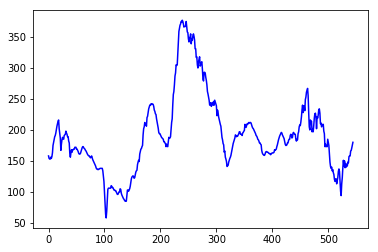

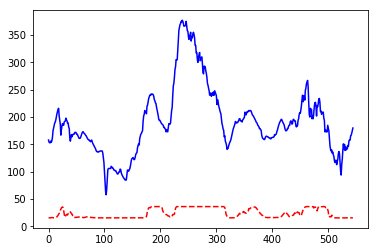

In [4]:
pre_List = []
for loop in range(len(test_x_data)):
    for i,k in enumerate(test_x_data[0]):
        ln = sess.run(Y_pre,feed_dict={X:[k],A1c:A1c_test[0]})
        #print("실제혈당 : "+str(test_y_data[0][i])+"예측혈당 : "+str(ln[0][0]))
        pre_List.append(ln[0][0])
        #print([sess.run(Y_p,feed_dict={X:[k]})[0][0],10.0])
    break;

print("loop end")

rmse_total = 0.0
rmse_one = 0.0
total_num = 0
one_person_num = 0
for size in range(len(test_x_data)):
    one_person_num = 0
    rmse_one = 0
    for i,k in enumerate(test_x_data[size]):
        total_num += 1
        one_person_num += 1
        #print(sess.run(rmse,feed_dict={X:[k],Y:[test_y_data[size][i]],A1c:[A1c_test[size][i]],G:[glucose_test[size][i]]}))
        tmp = sess.run(rmse,feed_dict={X:[k],Y:[test_y_data[size][i]],A1c:[A1c_test[size][i]]})
        rmse_total += tmp
        rmse_one += tmp
    #print(str(size+1)+"번째 환자 rmse : "+str(rmse_one/float(one_person_num)))

rmse_total = rmse_total / float(total_num)
print("전체 평균 rmse : "+str(rmse_total))

plt.plot(test_y_data[0],color="blue")
plt.show()

plt.plot(pre_List,'--',color="red")
plt.plot(test_y_data[0],color="blue")
plt.show()